### Imports

In [1]:
%load_ext autoreload
%autoreload 2
from convnet import ConvDipNet
from timeDistributed import TimeDistributed
from torchinfo import summary
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import sys; sys.path.insert(0, '../')
from esinet.forward import create_forward_model, get_info
from esinet import Simulation
from copy import deepcopy
from CNN_LSTM.util import *
from dipoleDataset import DipoleDataset
import os
import mne

2025-11-27 08:30:42.510629: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 08:30:42.565423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 08:30:43.499322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Model Definition

In [2]:
# define hyperparameters
in_channels = 1
im_shape = (9,9)
n_filters = 8
kernel_size = (3,3)

# create single input ConvDipNet 
convnet: nn.Module  = ConvDipNet(in_channels, im_shape, n_filters, kernel_size)

# create TimeDistributed ConvDipNet to process all samples of timeseries at once
time_distributed_convnet: nn.Module = TimeDistributed(convnet, batch_first=True) # change batch_first to False for now for evaluation, will change back later

# print model summary
summary(convnet, input_size=(32, 1, im_shape[0], im_shape[1])) # (batch_size, n_timesteps, in_channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
ConvDipNet                               [32, 5124]                --
├─Conv2d: 1-1                            [32, 8, 9, 9]             80
├─BatchNorm2d: 1-2                       [32, 8, 9, 9]             16
├─Linear: 1-3                            [32, 512]                 332,288
├─BatchNorm1d: 1-4                       [32, 512]                 1,024
├─Linear: 1-5                            [32, 5124]                2,628,612
Total params: 2,962,020
Trainable params: 2,962,020
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 94.99
Input size (MB): 0.01
Forward/backward pass size (MB): 1.91
Params size (MB): 11.85
Estimated Total Size (MB): 13.76

### Create forward model for simulations

In [4]:
# create forward model
fs = 100
info = get_info(sfreq=fs)
fwd = create_forward_model(sampling='ico4', info=info)
mne.write_forward_solution("/mnt/data/convdip/training_data/fwd_model-fwd.fif", fwd, overwrite=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  80 | elapsed:    5.6s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  35 out of  80 | elapsed:    5.7s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  52 out of  80 | elapsed:    5.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  69 out of  80 | elapsed:    5.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  80 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  80 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  52 out of  80 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  69 out of  80 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80

Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


/tmp/ipykernel_365894/2813673332.py:5: RuntimeWarning: This forward solution is based on a forward solution with free orientation. The original forward solution is stored on disk in X/Y/Z RAS coordinates. Any transformation (surface orientation or fixed orientation) will be reverted. To reapply any transformation to the forward operator please apply convert_forward_solution after reading the forward solution with read_forward_solution.
  mne.write_forward_solution("/mnt/data/convdip/training_data/fwd_model-fwd.fif", fwd, overwrite=True)


0 files missing from root.txt in /home/zbalkhy/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/zbalkhy/mne_data/MNE-fsaverage-data/fsaverage
Using surface: /home/zbalkhy/mne_data/MNE-fsaverage-data/fsaverage/bem/inner_skull.surf
Using surface: /home/zbalkhy/mne_data/MNE-fsaverage-data/fsaverage/bem/outer_skull.surf
Using surface: /home/zbalkhy/mne_data/MNE-fsaverage-data/fsaverage/bem/outer_skin.surf


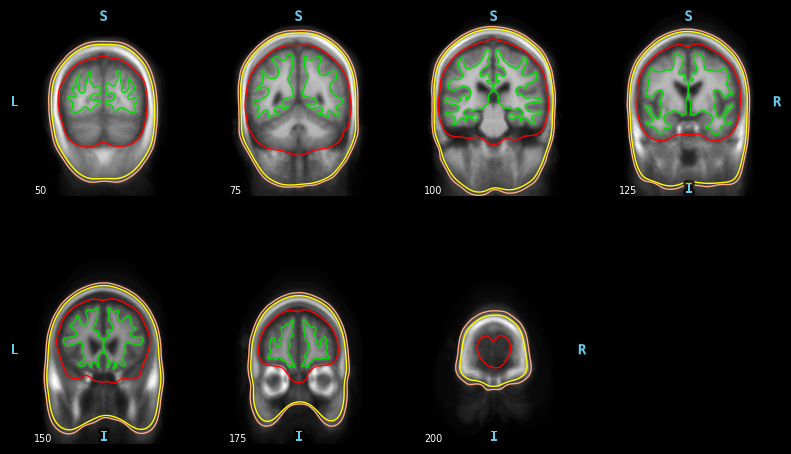

In [4]:
# plot BEM
import mne
import os
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)
plot_bem_kwargs = dict(
    subject='fsaverage',
    subjects_dir=subjects_dir,
    brain_surfaces="white",
    orientation="coronal", # "axial" for top down, "coronal" for front, "sagittal" for side
    slices=[50, 75, 100, 125, 150, 175, 200],
)
mne.viz.plot_bem(**plot_bem_kwargs)


### Run simulations to create train/test/validation data

In [5]:
# define simulation settings
n_samples = 2
settings = dict(number_of_sources=(1, 5), extents=(21, 58)) # settings from paper

# create simulation data using forward model
sim = Simulation(fwd, info, settings=settings, parallel=False).simulate(n_samples=n_samples)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 15.97it/s]


In [ ]:
from tqdm import tqdm
save_dir = "/mnt/data/convdip/training_data/bbb"
for i in tqdm(range(len(sim.eeg_data)), desc="samples"):
    np.save(os.path.join(save_dir, "eeg_data/sample_{}.npy".format(i)), sim.eeg_data[i].get_data(copy=False).squeeze())

for i in tqdm(range(len(sim.source_data)), desc="sources"):
    np.save(os.path.join(save_dir, "source_data/source_{}.npy".format(i)), sim.source_data[i].data)

np.save(os.path.join(save_dir, "dipole_pos.npy"), sim.pos)
sim.simulation_info.to_pickle(os.path.join(save_dir, 'simulation_info.pkl'))

sources: 100%|██████████| 100000/100000 [31:12<00:00, 53.41it/s]


In [8]:
# extract eeg and source data as numpy arrays
eeg_data = np.array([sim.eeg_data[i].get_data(copy=False).squeeze() for i in range(len(sim.eeg_data))]) 
source_data = np.array([sim.source_data[i].data for i in range(len(sim.source_data))])

### Rescale and interpolate data

In [ ]:
x_scaled = scale_eeg(eeg_data)
x_scaled = [np.swapaxes(x,0,1) for x in eeg_data]

y_scaled  = scale_source(source_data)
y_scaled = [np.swapaxes(y,0,1) for y in source_data]

print(len(x_scaled), x_scaled[0].shape)  # should be (n_samples, n_timesteps, n_channels)
print(len(y_scaled), y_scaled[0].shape)  # should be (n_samples, n_timesteps, n_dipoles)

100 (100, 61)
100 (100, 5124)


In [10]:
info = sim.eeg_data[0].info
x_scaled = interpolate_eeg(x_scaled, im_shape, info)

print(len(x_scaled), x_scaled[0].shape)  # should be (n_samples, n_timesteps, n_channels, im_height, im_width)

100 (100, 1, 7, 7)


In [ ]:
# open raw each eeg data file, scale and interpolate it, then save it back to a new file
eeg_data_path = "/mnt/data/convdip/training_data/eeg_data"
info = mne.io.read_info("/mnt/data/convdip/training_data/info.fif")
eeg_interpolated_path = "/mnt/data/convdip/training_data/interpolated_eeg_data"

x_scaled = []
for r, d, files in os.walk(eeg_data_path):
    for file in tqdm(files, desc="loader"):
        x_scaled.append(np.load(os.path.join(eeg_data_path, file)))

x_scaled = scale_eeg(x_scaled)
x_scaled = [np.swapaxes(x,0,1) for x in x_scaled]
x_scaled = interpolate_eeg(x_scaled, im_shape, info)

for i, x in enumerate(tqdm(x_scaled, desc="saver")):
    np.save(os.path.join(eeg_interpolated_path, "sample_{}.npy".format(i)), x_scaled)

interpolator:   2%|▏         | 2040/100000 [05:09<3:42:43,  7.33it/s]

### Split and batch data with a Dataloader

In [7]:
data_dir = "/mnt/data/convdip/training_data/"
eeg_data_dir = os.path.join(data_dir, "interp_data")
source_data_dir = os.path.join(data_dir, "source_data")
info_path = os.path.join(data_dir, "info.fif")
dataset = DipoleDataset(eeg_data_dir, source_data_dir, info_path, im_shape=im_shape)
test_size = 0.15
val_size = 0.15

test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

# this function will automatically randomly split your dataset but you could also implement the split yourself
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [
            (dataset.__len__() - (test_amount + val_amount)), 
            test_amount, 
            val_amount
])

In [42]:
B = 256  # batch size
train_dataloader = torch.utils.data.DataLoader(
            train_set,
            batch_size=B,
            shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=B,
            shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_set,
            batch_size=B,
            shuffle=True,
)

In [43]:

def weighted_MSE_loss(outputs, targets):
    weights = torch.softmax(targets, dim=-1) # sum along the dipole dimension
    error = (targets-outputs)**2
    return torch.mean(weights*error)


### Train Loop

In [44]:
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
lr = 0.001
betas=(0.9, 0.999)
eps = 1e-8
optimizer = optim.Adam(time_distributed_convnet.parameters(), lr=lr, 
                       betas=betas, eps=eps)

loss_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
time_distributed_convnet.to(device)
for epoch in range(500):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0
    for j, data in enumerate(tqdm(train_dataloader)):
        sample, target = data
        sample, target = sample.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = time_distributed_convnet(sample)
        loss = weighted_MSE_loss(outputs, target)#criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.8e}')
        i += 1
    loss_values.append(running_loss)

print('Finished Training')

Using device: cuda


 44%|████▍     | 120/274 [02:38<03:23,  1.32s/it]


KeyboardInterrupt: 

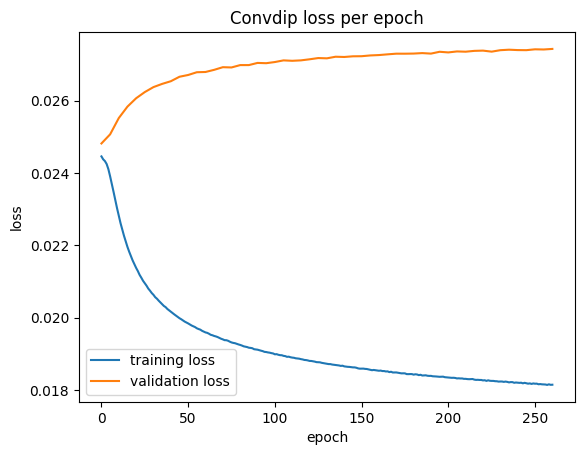

In [2]:
from matplotlib import pyplot as plt
import numpy as np
loss_values = np.load("/mnt/data/convdip/model/convdip_run4/convdip_contrastive_loss.npy")
val_loss = np.load("/mnt/data/convdip/model/convdip_run4/convdip_contrastive_val_loss.npy")
plt.title("Convdip loss per epoch")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(np.arange(0,261), np.array(loss_values/70000))
plt.plot(np.arange(0,261,5), np.array(val_loss/15000))
plt.legend(["training loss", "validation loss"])
plt.show()

### Evaluate AUC, MSE, nMSE, MLE

In [ ]:
from esinet.evaluate import eval_auc, eval_nmse, eval_mse, eval_mean_localization_error

model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

pos = sim.pos
print(pos.shape)
with torch.no_grad():
    all_auc = []
    all_mse = []
    all_nmse = []
    all_mle = []
    for sample, target in tqdm(val_dataloader, position=0, desc="sample"):
        sample = sample.cuda()
        output = time_distributed_convnet(sample)
        output = output.cpu()
        # reshape to remove extra dimension
        target = target.view(100,5124)
        output = output.view(100,5124)
        sample_auc = 0
        sample_mle = 0
        sample_mse = 0
        sample_nmse = 0
        num_timesteps = target.shape[0]
        for ts in tqdm(range(num_timesteps), position=1, desc="timestep", leave=False):
            target_ts = np.array(target[ts, :])
            output_ts = np.array(output[ts,:])
            
            auc_close, auc_far = eval_auc(target_ts, output_ts, pos)
            sample_auc += auc_close + auc_far
            
            mle = eval_mean_localization_error(target_ts, output_ts, pos)
            mse = eval_mse(target_ts, output_ts)
            nmse = eval_nmse(target_ts, output_ts)

        sample_auc = sample_auc/(2*num_timesteps)
        sample_mle = sample_mle/num_timesteps
        sample_mse = sample_mse/num_timesteps
        sample_nmse = sample_nmse/num_timesteps
        all_auc.append(sample_auc)
        all_mle.append(sample_mle)
        all_mse.append(sample_mse)
        all_nmse.append(sample_nmse)


(5124, 3)


sample:   0%|          | 0/15 [01:50<?, ?it/s]


KeyboardInterrupt: 

(20, 1, 9, 9)
(61, 20)


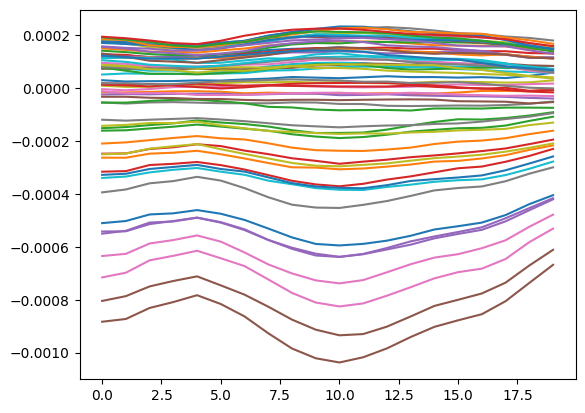

In [ ]:
from matplotlib import pyplot as plt

data_dir = "/mnt/data/convdip/training_data/"
eeg_data_dir = os.path.join(data_dir, "eeg_data")
interp_data_dir = os.path.join(data_dir, "interpolated_eeg_data_for_lstm")
eeg = np.load(os.path.join(eeg_data_dir, "sample_9.npy"))
max_idx = np.unravel_index(np.argmax(eeg), eeg.shape)[1]
eeg = eeg[:, np.max((max_idx-10, 0)):np.min((eeg.shape[1]-1, max_idx+10))]

interp_sample = np.load(os.path.join(interp_data_dir, "sample_9.npy"))
interp_sample = interp_sample[np.max((max_idx-10, 0)):np.min((interp_sample.shape[0]-1, max_idx+10))]
print(interp_sample.shape)
print(eeg.shape)
plt.plot(eeg.T)
plt.show()

In [24]:
import torch
A = torch.randn(512, 5124)
torch.sum(A, dim=1).shape

torch.Size([512])